Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. <br>
SPDX-License-Identifier: CC-BY-NC-4.0

# Simple Example

This example shows how to prune a simple feed forward network that we trained on the Fashion-MNIST dataset. We refer to this model as the "Garment Classifier". If your model is an LLM, please see `simple_example_llm.ipynb` instead. 

### Imports 

In [1]:
import multiprocessing

import os
import pickle
import time
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from garment_classifier import load_fashion_mnist, load_garment_classifier
from icbs.evaluation import evaluate_model
from icbs.loops import prune_loop
from icbs.pruner import Pruner
from icbs.solvers import ConstrainedSASolver
from icbs.util import calc_density, get_log_w_names_step, get_named_weights
from util import load_dataset, set_num_threads, set_seed

### Settings

Some settings are chosen specifically so that this notebook can be run in a short time.  In such cases, the settings used for this model in the paper are included after the # symbol.

In [2]:
# Model and dataset
model_name = "garment_classifier"
dataset_name = "zalando-datasets/fashion_mnist"
dataset_args = {}
device = "cuda" if torch.cuda.is_available() else "cpu"

# Pruner parameters
seed = 43
density = 0.1
pruner_num_epochs = 10
num_steps_per_epoch = 3  # 300
init_method = "magnitude"
block_size = 1024
num_restarts = 10
min_num_steps_per_layer = 1
selection_method = "gradient"
calc_hessian_method = "gradient_per_sample"
grad_multiplier = 0.75
ridge_multiplier = 0.001
verbose = 2

# Batch sizes
batch_size_evaluation = 4096
batch_size_pruning = 200
batch_size_calibration = 4096
max_batch_size = None  # Small dataset - don't need accumulation

# Block settings
block_solver = ConstrainedSASolver(verbose=verbose, num_restarts=num_restarts)
k = block_size // 2
tabu_frac = 0.40
fix_frac_prune = 0.42
fix_frac_keep = 0.35

# Workers, etc.
num_cpus = multiprocessing.cpu_count()
dataloader_args = {
    "num_workers": 4 if torch.cuda.is_available() else 0,
    "pin_memory": False,
}

# Only prune linear layers and do not prune the final layer
keep_layers = (torch.nn.Linear,)
layer_name_to_exclude = None

# The loss function
loss_function = nn.CrossEntropyLoss()

# Set the number of threads and seed the random number generator
set_num_threads(num_cpus)
set_seed(seed)

## Load a model

When running on a machine with multiple GPUs, the print out below this cell will show the distribution of the model across GPUs. 

In [3]:
# Load a fresh model
# Note: it's important to load the model before getting a reference
# to the weights (below)
model = load_garment_classifier(device)

Choose which layer to prune at each step. 

In [4]:
# The list of layers to process
named_weights = get_named_weights(model, keep_layers)
named_weights = {
    name: weights
    for name, weights in named_weights.items()
    if layer_name_to_exclude is None or layer_name_to_exclude not in name
}
layer_names = list(named_weights.keys())
print(f"Pruning {len(layer_names)} layers")

# The distribution of steps to weights
w_names_step = get_log_w_names_step(
    named_weights, num_steps_per_epoch, min_num_steps_per_layer
)

Pruning 3 layers


## Load a dataset

First we load the dataset:

In [5]:
train_dataset, valid_dataset = load_fashion_mnist()

Then we set up data loaders for pruning and validation:

In [6]:
# Pruning dataloader
prune_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size_pruning,
    shuffle=False,
    **dataloader_args,
)

# Data loader
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size_evaluation,
    shuffle=False,
    **dataloader_args,
)

If the initial selection of weights to prune is done using Wanda or the Gradient option, then we also need to provide the calibaration data:

In [7]:
if init_method.startswith("wanda") or init_method.startswith("gradient"):
    calibration_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size_calibration,
        shuffle=False,  # Set to True for any dataset that is not streamed
        **dataloader_args,
    )
    X_init, y_init = next(iter(calibration_dataloader))

else:
    X_init, y_init = None, None

## Evaluate the model (before pruning)

We check the performance of the model before pruning, as a point of reference: 

In [14]:
print("Evaluating model before pruning:")
unpruned_evaluation_start_time = time.time()
unpruned_valid_accuracy, unpruned_valid_loss, unpruned_evaluation_time = evaluate_model(
    valid_dataloader, model, loss_function, device
)
unpruned_evaluation_time = time.time() - unpruned_evaluation_start_time
print(f"Initial evaluation took: {unpruned_evaluation_time/60:.2f}min")

Evaluating model before pruning:
  Accuracy: 82.64%, Loss: 0.855576
  Evaluation time: evaluation_time=1.6sec
Initial evaluation took: 0.03min


## Run 

For demonstration purposes, the below will even run on a CPU and should take a few minutes (depending on the specs). However, we recommend running any actual experiments on a machine with at least one GPU. First we instantiate the pruner, which will already perform the initial pruning:

In [9]:
initial_pruning_start_time = time.time()

print("*" * 80)
print(
    f"Pruning weights across all layers using {density=} "
    f"block_solver={block_solver.__class__.__name__} "
    f"{block_size=} {k=} {init_method=} {selection_method=} "
    f"{grad_multiplier=} {ridge_multiplier=} {calc_hessian_method=} "
    f"{seed=} {tabu_frac=} {fix_frac_prune=} {fix_frac_keep=} \n"
)

pruner = Pruner(
    model,
    loss_function,
    density,
    block_solver,
    block_size,
    k,
    layer_names,
    init_method,
    selection_method,
    grad_multiplier,
    ridge_multiplier,
    calc_hessian_method,
    seed,
    verbose,
    X_init=X_init,
    y_init=y_init,
    tabu_frac=tabu_frac,
    fix_frac_prune=fix_frac_prune,
    fix_frac_keep=fix_frac_keep,
    max_batch_size=max_batch_size,
)

print(f"Target density: {density} Actual density: {calc_density(model):.4f}")

print("Evaluating model after initial pruning:")
valid_accuracy, valid_loss, evaluation_time = evaluate_model(
    valid_dataloader, model, loss_function, device
)

initial_pruning_time = time.time() - initial_pruning_start_time
print(f"Initial pruning and validation took: {initial_pruning_time/60:.2f}min")

********************************************************************************
Pruning weights across all layers using density=0.1 block_solver=ConstrainedSASolver block_size=1024 k=512 init_method='magnitude' selection_method='gradient' grad_multiplier=0.75 ridge_multiplier=0.001 calc_hessian_method='gradient_per_sample' seed=43 tabu_frac=0.4 fix_frac_prune=0.42 fix_frac_keep=0.35 

Resetting pruner
Performing initial pruning on layer linear_relu_stack.linear1.weight
w_name='linear_relu_stack.linear1.weight', num_weights=401408, self.density=0.1, num_fix_keep=14049, num_fix_prune=151732
Done with initial pruning of layer linear_relu_stack.linear1.weight, layer_density=0.100
    _perform_init_pruning_layer() took: 0.33s
Performing initial pruning on layer linear_relu_stack.linear2.weight
w_name='linear_relu_stack.linear2.weight', num_weights=262144, self.density=0.1, num_fix_keep=9175, num_fix_prune=99091
Done with initial pruning of layer linear_relu_stack.linear2.weight, layer_dens

Then we run the optimization-based pruning steps to (hopefully) improve on the initial pruning:

In [10]:
experiment_start_time = time.time()

valid_losses = [valid_loss]
valid_accuracies = [valid_accuracy]
prune_times = [0.0]
evaluation_times = [evaluation_time]
for num_epoch in range(1, pruner_num_epochs + 1):
    print("-" * 80)
    print(f"{num_epoch=}")
    start_time = time.time()
    w_names_step = np.random.permutation(w_names_step)
    prune_loop(
        prune_dataloader,
        model,
        pruner,
        device,
        w_names_step,
        verbose=1 if verbose else None,
    )
    prune_time = time.time() - start_time

    print(f"\nEvaluating model after epoch {num_epoch}:")
    valid_accuracy, valid_loss, evaluation_time = evaluate_model(
        valid_dataloader, model, loss_function, device
    )
    print(f"  Time: {prune_time=:.1f}sec\n")

    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    prune_times.append(prune_time)
    evaluation_times.append(evaluation_time)

experiment_time = time.time() - experiment_start_time
print(f"Experiment took: {experiment_time/60:.2f}min")

--------------------------------------------------------------------------------
num_epoch=1
-----------------------
Pruner step 1 (of 3)
    Calculated gradient in 0.06s
    w_name='linear_relu_stack.linear2.weight' k_effective=512
    _calc_grad_sample_block() took: 0.08s
    _calc_hess_block() took: 0.08s
    scaling=5.580e+05 cutoff=1.000e-12 Q_density=0.25048 Q_density_cutoff=0.13147
    Solving with ConstrainedSASolver, problem_filename=PosixPath('.41412_241104_104955835866_22d22c7037074c01a12411673da1b304.tmp')
    n=1024 best_E=520.142 elapsed_time=1.992
    dL=-0.076 dE=-0.075 ridge_contribution=0.002 const=-0.076 best_E=0.001 dL_eval=-0.061 delta_w_squared=1.537
    Pruner step took: 3.64s
-----------------------
Pruner step 2 (of 3)
    Calculated gradient in 0.06s
    w_name='linear_relu_stack.linear1.weight' k_effective=512
    _calc_grad_sample_block() took: 0.11s
    _calc_hess_block() took: 0.12s
    scaling=5.292e+06 cutoff=1.000e-12 Q_density=0.77473 Q_density_cutoff=

## Plot the results

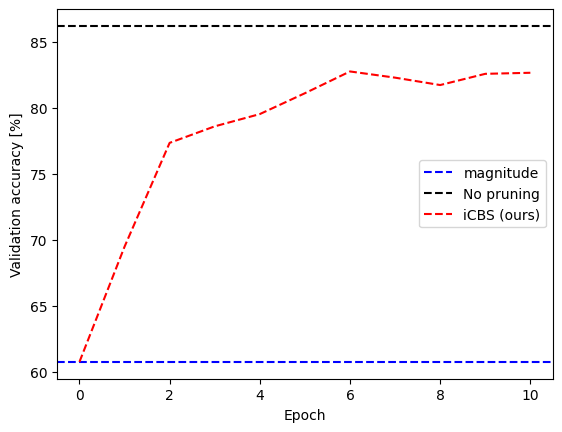

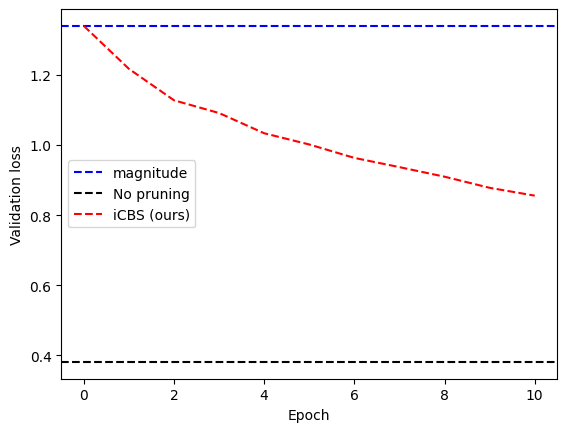

In [13]:
# Plot the evolution of the validation accuracy across epochs
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy [%]")
plt.axhline(y=valid_accuracies[0], linestyle="--", label=f"{init_method}", color="b")
plt.axhline(y=unpruned_valid_accuracy, linestyle="--", label=f"No pruning", color="k")
plt.plot(valid_accuracies, label="iCBS (ours)", linestyle="--", color="r")
plt.legend()

# Plot the evolution of the validation accuracy across epochs
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.axhline(y=valid_losses[0], linestyle="--", label=f"{init_method}", color="b")
plt.axhline(y=unpruned_valid_loss, linestyle="--", label=f"No pruning", color="k")
plt.plot(valid_losses, label="iCBS (ours)", linestyle="--", color="r")
plt.legend();